# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   book    1206 non-null   object
 1   str     1206 non-null   int64 
 2   int     1206 non-null   int64 
 3   con     1206 non-null   int64 
 4   hp      1206 non-null   int64 
 5   cha     1206 non-null   int64 
 6   level   1206 non-null   int64 
 7   wis     1206 non-null   int64 
 8   ac      1206 non-null   int64 
 9   dex     1206 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 103.6+ KB


In [3]:
df.head()

,book,str,int,con,hp,cha,level,wis,ac,dex
0,Pathfinder Bestiary,7,1,5,215,1,10,2,29,2
1,Pathfinder Bestiary,9,-4,5,220,1,10,2,28,0
2,Pathfinder Bestiary,7,-4,6,175,-2,8,3,25,3
3,Pathfinder Bestiary,7,6,5,315,6,17,5,41,4
4,Pathfinder Bestiary,-5,-1,1,20,1,1,1,16,3


###### Level

In [4]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


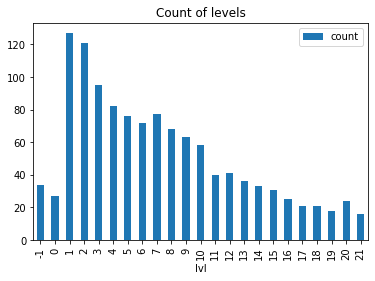

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [10]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [11]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 8
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [13]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.67
MAE: 0.47


In [15]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "basic", rmse, mae]

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.31
RMSE test: 0.67


###### MAE by level

In [17]:
from training.results import plot_mae_by_level

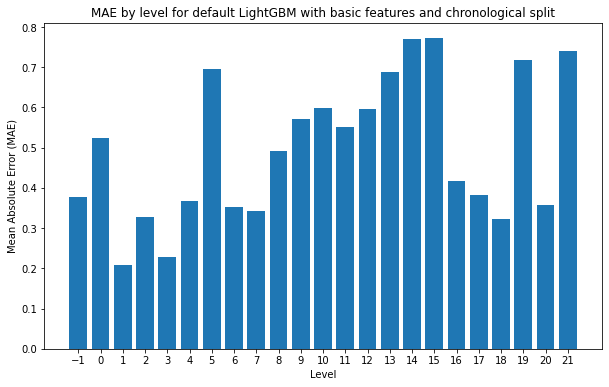

In [18]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default LightGBM with basic features and chronological split",
)

In [19]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions([0.5, 0.33, 0.45], y_test, y_pred_test)

Default:
RMSE: 0.67

Round type: 0.5
RMSE: 0.71

Round type: 0.33
RMSE: 0.71

Round type: 0.45
RMSE: 0.70



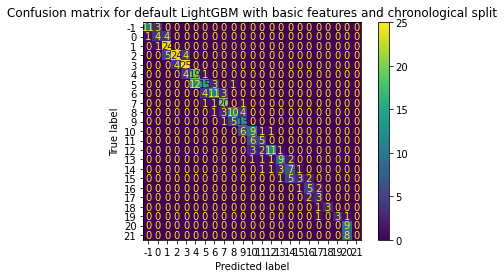

In [20]:
plot_confusion_matrix(
    y_pred_test,
    y_test,
    title="Confusion matrix for default LightGBM with basic features and chronological split",
)

#### Tuning

In [21]:
from training.results import assess_regression_model

In [22]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-05 13:55:55,056] A new study created in memory with name: no-name-6e869279-c20c-46f8-b9ec-f72c8d86904c
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.266916 + 0.05786
[200]	cv_agg's l2: 0.246561 + 0.0537578
[300]	cv_agg's l2: 0.239493 + 0.0493101
[400]	cv_agg's l2: 0.237348 + 0.0470236


feature_fraction, val_score: 0.237065:  14%|######4                                      | 1/7 [00:01<00:09,  1.54s/it]

[500]	cv_agg's l2: 0.237312 + 0.0455104
Early stopping, best iteration is:
[415]	cv_agg's l2: 0.237065 + 0.0464962
[100]	cv_agg's l2: 0.239584 + 0.0391049
[200]	cv_agg's l2: 0.227879 + 0.0403135
[300]	cv_agg's l2: 0.224411 + 0.0414691


feature_fraction, val_score: 0.223460:  29%|############8                                | 2/7 [00:02<00:07,  1.47s/it]

[400]	cv_agg's l2: 0.224319 + 0.0418182
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102
[100]	cv_agg's l2: 0.259417 + 0.0731179
[200]	cv_agg's l2: 0.247169 + 0.0660463
[300]	cv_agg's l2: 0.242625 + 0.0639469


feature_fraction, val_score: 0.223460:  29%|############8                                | 2/7 [00:04<00:07,  1.47s/it]

[400]	cv_agg's l2: 0.24306 + 0.0631203
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102


feature_fraction, val_score: 0.223460:  43%|###################2                         | 3/7 [00:04<00:06,  1.51s/it]

[100]	cv_agg's l2: 0.23413 + 0.0515182
[200]	cv_agg's l2: 0.232574 + 0.049644
[300]	cv_agg's l2: 0.234584 + 0.0510205


feature_fraction, val_score: 0.223460:  57%|#########################7                   | 4/7 [00:05<00:04,  1.47s/it]

[400]	cv_agg's l2: 0.238109 + 0.0529093
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102
[100]	cv_agg's l2: 0.23663 + 0.044165
[200]	cv_agg's l2: 0.227741 + 0.0453552
[300]	cv_agg's l2: 0.22723 + 0.0455129


feature_fraction, val_score: 0.223460:  71%|################################1            | 5/7 [00:07<00:02,  1.49s/it]

[400]	cv_agg's l2: 0.227439 + 0.0454726
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102
[100]	cv_agg's l2: 0.234156 + 0.0509227
[200]	cv_agg's l2: 0.230507 + 0.047911
[300]	cv_agg's l2: 0.232939 + 0.0478838


feature_fraction, val_score: 0.223460:  86%|######################################5      | 6/7 [00:08<00:01,  1.46s/it]

[400]	cv_agg's l2: 0.235209 + 0.0487979
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102
[100]	cv_agg's l2: 0.23663 + 0.044165
[200]	cv_agg's l2: 0.227741 + 0.0453552
[300]	cv_agg's l2: 0.22723 + 0.0455129


feature_fraction, val_score: 0.223460: 100%|#############################################| 7/7 [00:10<00:00,  1.49s/it]


[400]	cv_agg's l2: 0.227439 + 0.0454726
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102


num_leaves, val_score: 0.223460:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.239584 + 0.0391049
[200]	cv_agg's l2: 0.227879 + 0.0403135
[300]	cv_agg's l2: 0.224411 + 0.0414691


num_leaves, val_score: 0.223460:   5%|##5                                               | 1/20 [00:01<00:28,  1.51s/it]

[400]	cv_agg's l2: 0.224319 + 0.0418182
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102
[100]	cv_agg's l2: 0.239584 + 0.0391049
[200]	cv_agg's l2: 0.227879 + 0.0403135
[300]	cv_agg's l2: 0.224411 + 0.0414691


num_leaves, val_score: 0.223460:  10%|#####                                             | 2/20 [00:02<00:26,  1.47s/it]

[400]	cv_agg's l2: 0.224319 + 0.0418182
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102
[100]	cv_agg's l2: 0.239584 + 0.0391049
[200]	cv_agg's l2: 0.227879 + 0.0403135
[300]	cv_agg's l2: 0.224411 + 0.0414691


num_leaves, val_score: 0.223460:  10%|#####                                             | 2/20 [00:04<00:26,  1.47s/it]

[400]	cv_agg's l2: 0.224319 + 0.0418182
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102


num_leaves, val_score: 0.223460:  15%|#######5                                          | 3/20 [00:04<00:25,  1.49s/it]

[100]	cv_agg's l2: 0.239584 + 0.0391049
[200]	cv_agg's l2: 0.227879 + 0.0403135
[300]	cv_agg's l2: 0.224411 + 0.0414691


num_leaves, val_score: 0.223460:  20%|##########                                        | 4/20 [00:05<00:23,  1.49s/it]

[400]	cv_agg's l2: 0.224319 + 0.0418182
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102
[100]	cv_agg's l2: 0.239584 + 0.0391049
[200]	cv_agg's l2: 0.227879 + 0.0403135
[300]	cv_agg's l2: 0.224411 + 0.0414691


num_leaves, val_score: 0.223460:  25%|############5                                     | 5/20 [00:07<00:22,  1.53s/it]

[400]	cv_agg's l2: 0.224319 + 0.0418182
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102
[100]	cv_agg's l2: 0.239584 + 0.0391049
[200]	cv_agg's l2: 0.227879 + 0.0403135
[300]	cv_agg's l2: 0.224411 + 0.0414691


num_leaves, val_score: 0.223460:  30%|###############                                   | 6/20 [00:09<00:21,  1.54s/it]

[400]	cv_agg's l2: 0.224319 + 0.0418182
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102
[100]	cv_agg's l2: 0.239584 + 0.0391049
[200]	cv_agg's l2: 0.227879 + 0.0403135
[300]	cv_agg's l2: 0.224411 + 0.0414691


num_leaves, val_score: 0.223460:  35%|#################5                                | 7/20 [00:10<00:19,  1.49s/it]

[400]	cv_agg's l2: 0.224319 + 0.0418182
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102
[100]	cv_agg's l2: 0.239584 + 0.0391049
[200]	cv_agg's l2: 0.227879 + 0.0403135
[300]	cv_agg's l2: 0.224411 + 0.0414691
[400]	cv_agg's l2: 0.224319 + 0.0418182
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102


num_leaves, val_score: 0.223460:  40%|####################                              | 8/20 [00:12<00:18,  1.50s/it]

[100]	cv_agg's l2: 0.239584 + 0.0391049
[200]	cv_agg's l2: 0.227879 + 0.0403135
[300]	cv_agg's l2: 0.224411 + 0.0414691


num_leaves, val_score: 0.223460:  45%|######################5                           | 9/20 [00:13<00:16,  1.50s/it]

[400]	cv_agg's l2: 0.224319 + 0.0418182
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102
[100]	cv_agg's l2: 0.239584 + 0.0391049
[200]	cv_agg's l2: 0.227879 + 0.0403135
[300]	cv_agg's l2: 0.224411 + 0.0414691


num_leaves, val_score: 0.223460:  45%|######################5                           | 9/20 [00:15<00:16,  1.50s/it]

[400]	cv_agg's l2: 0.224319 + 0.0418182
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102


num_leaves, val_score: 0.223460:  50%|########################5                        | 10/20 [00:15<00:15,  1.58s/it]

[100]	cv_agg's l2: 0.392295 + 0.0550109
[200]	cv_agg's l2: 0.328814 + 0.0524091
[300]	cv_agg's l2: 0.309534 + 0.0510877
[400]	cv_agg's l2: 0.303637 + 0.0505597


num_leaves, val_score: 0.223460:  55%|##########################9                      | 11/20 [00:15<00:10,  1.21s/it]

Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102
[100]	cv_agg's l2: 0.239584 + 0.0391049
[200]	cv_agg's l2: 0.227879 + 0.0403135
[300]	cv_agg's l2: 0.224411 + 0.0414691


num_leaves, val_score: 0.223460:  55%|##########################9                      | 11/20 [00:17<00:10,  1.21s/it]

[400]	cv_agg's l2: 0.224319 + 0.0418182
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102


num_leaves, val_score: 0.223460:  60%|#############################4                   | 12/20 [00:17<00:11,  1.38s/it]

[100]	cv_agg's l2: 0.239584 + 0.0391049
[200]	cv_agg's l2: 0.227879 + 0.0403135
[300]	cv_agg's l2: 0.224411 + 0.0414691
[400]	cv_agg's l2: 0.224319 + 0.0418182
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102


num_leaves, val_score: 0.223460:  65%|###############################8                 | 13/20 [00:19<00:10,  1.52s/it]

[100]	cv_agg's l2: 0.239584 + 0.0391049
[200]	cv_agg's l2: 0.227879 + 0.0403135
[300]	cv_agg's l2: 0.224411 + 0.0414691


num_leaves, val_score: 0.223460:  65%|###############################8                 | 13/20 [00:20<00:10,  1.52s/it]

[400]	cv_agg's l2: 0.224319 + 0.0418182
Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102


num_leaves, val_score: 0.223460:  70%|##################################3              | 14/20 [00:20<00:09,  1.55s/it]

[100]	cv_agg's l2: 0.239584 + 0.0391049
[200]	cv_agg's l2: 0.227879 + 0.0403135
[300]	cv_agg's l2: 0.224411 + 0.0414691
[400]	cv_agg's l2: 0.224319 + 0.0418182


num_leaves, val_score: 0.223460:  75%|####################################7            | 15/20 [00:22<00:08,  1.61s/it]

Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102
[100]	cv_agg's l2: 0.239584 + 0.0391049
[200]	cv_agg's l2: 0.227879 + 0.0403135
[300]	cv_agg's l2: 0.224411 + 0.0414691
[400]	cv_agg's l2: 0.224319 + 0.0418182


num_leaves, val_score: 0.223460:  80%|#######################################2         | 16/20 [00:25<00:08,  2.00s/it]

Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102
[100]	cv_agg's l2: 0.239584 + 0.0391049
[200]	cv_agg's l2: 0.227879 + 0.0403135
[300]	cv_agg's l2: 0.224411 + 0.0414691
[400]	cv_agg's l2: 0.224319 + 0.0418182


num_leaves, val_score: 0.223460:  85%|#########################################6       | 17/20 [00:28<00:06,  2.31s/it]

Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102
[100]	cv_agg's l2: 0.239584 + 0.0391049
[200]	cv_agg's l2: 0.227879 + 0.0403135
[300]	cv_agg's l2: 0.224411 + 0.0414691
[400]	cv_agg's l2: 0.224319 + 0.0418182


num_leaves, val_score: 0.223460:  90%|############################################1    | 18/20 [00:31<00:05,  2.53s/it]

Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102
[100]	cv_agg's l2: 0.239584 + 0.0391049
[200]	cv_agg's l2: 0.227879 + 0.0403135
[300]	cv_agg's l2: 0.224411 + 0.0414691
[400]	cv_agg's l2: 0.224319 + 0.0418182


num_leaves, val_score: 0.223460:  95%|##############################################5  | 19/20 [00:34<00:02,  2.67s/it]

Early stopping, best iteration is:
[349]	cv_agg's l2: 0.22346 + 0.0410102
[100]	cv_agg's l2: 0.241857 + 0.0432389
[200]	cv_agg's l2: 0.227311 + 0.0431656
[300]	cv_agg's l2: 0.223013 + 0.0417671
[400]	cv_agg's l2: 0.220909 + 0.0426
[500]	cv_agg's l2: 0.220054 + 0.0429191
[600]	cv_agg's l2: 0.218971 + 0.042328


num_leaves, val_score: 0.218971: 100%|#################################################| 20/20 [00:36<00:00,  1.84s/it]


[700]	cv_agg's l2: 0.219494 + 0.0435016
Early stopping, best iteration is:
[600]	cv_agg's l2: 0.218971 + 0.042328


bagging, val_score: 0.218971:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.244325 + 0.0446518
[200]	cv_agg's l2: 0.227008 + 0.0422661
[300]	cv_agg's l2: 0.220146 + 0.0418386
[400]	cv_agg's l2: 0.218286 + 0.0420508
[500]	cv_agg's l2: 0.215561 + 0.0416364


bagging, val_score: 0.214945:  10%|#####3                                               | 1/10 [00:02<00:20,  2.31s/it]

[600]	cv_agg's l2: 0.215358 + 0.0417498
Early stopping, best iteration is:
[552]	cv_agg's l2: 0.214945 + 0.0419983


[I 2023-11-05 13:56:44,668] Trial 27 finished with value: 0.21494504310542512 and parameters: {'bagging_fraction': 0.9756747219076327, 'bagging_freq': 5}. Best is trial 27 with value: 0.21494504310542512.
bagging, val_score: 0.214945:  10%|#####3                                               | 1/10 [00:02<00:20,  2.31s/it]

[100]	cv_agg's l2: 0.240766 + 0.0406813
[200]	cv_agg's l2: 0.224989 + 0.0382462
[300]	cv_agg's l2: 0.219853 + 0.0359699
[400]	cv_agg's l2: 0.217599 + 0.0375428
[500]	cv_agg's l2: 0.217498 + 0.0369336
[600]	cv_agg's l2: 0.217287 + 0.0377466
Early stopping, best iteration is:
[552]	cv_agg's l2: 0.214945 + 0.0419983


bagging, val_score: 0.214945:  20%|##########6                                          | 2/10 [00:04<00:18,  2.32s/it]

[100]	cv_agg's l2: 0.242096 + 0.0416648
[200]	cv_agg's l2: 0.228709 + 0.0388734
[300]	cv_agg's l2: 0.225054 + 0.038064
[400]	cv_agg's l2: 0.223489 + 0.0383231
[500]	cv_agg's l2: 0.22215 + 0.0378396


bagging, val_score: 0.214945:  30%|###############9                                     | 3/10 [00:07<00:16,  2.37s/it]

[600]	cv_agg's l2: 0.221666 + 0.0380138
Early stopping, best iteration is:
[552]	cv_agg's l2: 0.214945 + 0.0419983
[100]	cv_agg's l2: 0.242963 + 0.0451045
[200]	cv_agg's l2: 0.227303 + 0.0406807
[300]	cv_agg's l2: 0.221797 + 0.0405244
[400]	cv_agg's l2: 0.217538 + 0.040186
[500]	cv_agg's l2: 0.214158 + 0.0396143
[600]	cv_agg's l2: 0.213755 + 0.0401517


bagging, val_score: 0.213134:  40%|#####################2                               | 4/10 [00:10<00:15,  2.64s/it]

Early stopping, best iteration is:
[567]	cv_agg's l2: 0.213134 + 0.0401698
[100]	cv_agg's l2: 0.239022 + 0.0437043
[200]	cv_agg's l2: 0.227568 + 0.0428938
[300]	cv_agg's l2: 0.222432 + 0.0409974
[400]	cv_agg's l2: 0.22113 + 0.0423036
[500]	cv_agg's l2: 0.219013 + 0.0418921
[600]	cv_agg's l2: 0.218244 + 0.0412051


bagging, val_score: 0.213134:  50%|##########################5                          | 5/10 [00:13<00:13,  2.76s/it]

Early stopping, best iteration is:
[567]	cv_agg's l2: 0.213134 + 0.0401698
[100]	cv_agg's l2: 0.239409 + 0.0402639
[200]	cv_agg's l2: 0.226045 + 0.0402273
[300]	cv_agg's l2: 0.220233 + 0.03861
[400]	cv_agg's l2: 0.219375 + 0.0377631
[500]	cv_agg's l2: 0.218722 + 0.0377901
[600]	cv_agg's l2: 0.218843 + 0.0380826


bagging, val_score: 0.213134:  60%|###############################8                     | 6/10 [00:16<00:12,  3.10s/it]

Early stopping, best iteration is:
[567]	cv_agg's l2: 0.213134 + 0.0401698
[100]	cv_agg's l2: 0.242717 + 0.0438718
[200]	cv_agg's l2: 0.227701 + 0.0396211
[300]	cv_agg's l2: 0.221689 + 0.0386745
[400]	cv_agg's l2: 0.219873 + 0.03859
[500]	cv_agg's l2: 0.219645 + 0.0380612
[600]	cv_agg's l2: 0.218817 + 0.0390996


bagging, val_score: 0.213134:  70%|#####################################                | 7/10 [00:21<00:11,  3.68s/it]

Early stopping, best iteration is:
[567]	cv_agg's l2: 0.213134 + 0.0401698
[100]	cv_agg's l2: 0.245058 + 0.047207
[200]	cv_agg's l2: 0.226315 + 0.0410593
[300]	cv_agg's l2: 0.219916 + 0.0397012
[400]	cv_agg's l2: 0.216838 + 0.0398735
[500]	cv_agg's l2: 0.214705 + 0.0391276
[600]	cv_agg's l2: 0.213239 + 0.040233


bagging, val_score: 0.212764:  80%|##########################################4          | 8/10 [00:26<00:08,  4.01s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398657
[100]	cv_agg's l2: 0.258016 + 0.0439125
[200]	cv_agg's l2: 0.240446 + 0.0396093
[300]	cv_agg's l2: 0.230323 + 0.0360479
[400]	cv_agg's l2: 0.226243 + 0.0341804
[500]	cv_agg's l2: 0.226708 + 0.034419
[600]	cv_agg's l2: 0.223554 + 0.0328725


bagging, val_score: 0.212764:  90%|###############################################7     | 9/10 [00:30<00:04,  4.00s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398657
[100]	cv_agg's l2: 0.298463 + 0.0529056
[200]	cv_agg's l2: 0.279646 + 0.0550272
[300]	cv_agg's l2: 0.283876 + 0.0590339
[400]	cv_agg's l2: 0.274623 + 0.0545093
[500]	cv_agg's l2: 0.270723 + 0.0519848
[600]	cv_agg's l2: 0.274072 + 0.059752


bagging, val_score: 0.212764: 100%|####################################################| 10/10 [00:33<00:00,  3.40s/it]


Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398657


feature_fraction_stage2, val_score: 0.212764:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.245058 + 0.047207
[200]	cv_agg's l2: 0.226315 + 0.0410593
[300]	cv_agg's l2: 0.219916 + 0.0397012
[400]	cv_agg's l2: 0.216838 + 0.0398735
[500]	cv_agg's l2: 0.214705 + 0.0391276
[600]	cv_agg's l2: 0.213239 + 0.040233


feature_fraction_stage2, val_score: 0.212764:  17%|######3                               | 1/6 [00:03<00:17,  3.46s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398657
[100]	cv_agg's l2: 0.245058 + 0.047207
[200]	cv_agg's l2: 0.226315 + 0.0410593
[300]	cv_agg's l2: 0.219916 + 0.0397012
[400]	cv_agg's l2: 0.216838 + 0.0398735
[500]	cv_agg's l2: 0.214705 + 0.0391276
[600]	cv_agg's l2: 0.213239 + 0.040233


feature_fraction_stage2, val_score: 0.212764:  33%|############6                         | 2/6 [00:07<00:14,  3.59s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398657
[100]	cv_agg's l2: 0.268252 + 0.0676292
[200]	cv_agg's l2: 0.245692 + 0.0565488
[300]	cv_agg's l2: 0.241435 + 0.0534063
[400]	cv_agg's l2: 0.237468 + 0.0504061
[500]	cv_agg's l2: 0.237113 + 0.0486787
[600]	cv_agg's l2: 0.236919 + 0.0476788


feature_fraction_stage2, val_score: 0.212764:  50%|###################                   | 3/6 [00:10<00:10,  3.56s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398657
[100]	cv_agg's l2: 0.245058 + 0.047207
[200]	cv_agg's l2: 0.226315 + 0.0410593
[300]	cv_agg's l2: 0.219916 + 0.0397012
[400]	cv_agg's l2: 0.216838 + 0.0398735
[500]	cv_agg's l2: 0.214705 + 0.0391276
[600]	cv_agg's l2: 0.213239 + 0.040233


feature_fraction_stage2, val_score: 0.212764:  67%|#########################3            | 4/6 [00:14<00:07,  3.53s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398657
[100]	cv_agg's l2: 0.268252 + 0.0676292
[200]	cv_agg's l2: 0.245692 + 0.0565488
[300]	cv_agg's l2: 0.241435 + 0.0534063
[400]	cv_agg's l2: 0.237468 + 0.0504061
[500]	cv_agg's l2: 0.237113 + 0.0486787
[600]	cv_agg's l2: 0.236919 + 0.0476788


feature_fraction_stage2, val_score: 0.212764:  83%|###############################6      | 5/6 [00:17<00:03,  3.46s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398657
[100]	cv_agg's l2: 0.245058 + 0.047207
[200]	cv_agg's l2: 0.226315 + 0.0410593
[300]	cv_agg's l2: 0.219916 + 0.0397012
[400]	cv_agg's l2: 0.216838 + 0.0398735
[500]	cv_agg's l2: 0.214705 + 0.0391276
[600]	cv_agg's l2: 0.213239 + 0.040233


feature_fraction_stage2, val_score: 0.212764: 100%|######################################| 6/6 [00:21<00:00,  3.51s/it]


Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398657


regularization_factors, val_score: 0.212764:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.247142 + 0.0424216
[200]	cv_agg's l2: 0.229145 + 0.0388466
[300]	cv_agg's l2: 0.222614 + 0.0389383
[400]	cv_agg's l2: 0.220107 + 0.0384941
[500]	cv_agg's l2: 0.218742 + 0.0384135
[600]	cv_agg's l2: 0.218435 + 0.0391997


regularization_factors, val_score: 0.212764:   5%|#9                                    | 1/20 [00:04<01:31,  4.83s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398657
[100]	cv_agg's l2: 0.245058 + 0.047207
[200]	cv_agg's l2: 0.226315 + 0.0410593
[300]	cv_agg's l2: 0.219916 + 0.0397012
[400]	cv_agg's l2: 0.216838 + 0.0398735
[500]	cv_agg's l2: 0.214705 + 0.0391276
[600]	cv_agg's l2: 0.213239 + 0.040233


regularization_factors, val_score: 0.212764:  10%|###8                                  | 2/20 [00:08<01:13,  4.09s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398657
[100]	cv_agg's l2: 0.318785 + 0.035633
[200]	cv_agg's l2: 0.308671 + 0.0364544
[300]	cv_agg's l2: 0.307595 + 0.0373327
[400]	cv_agg's l2: 0.307452 + 0.0373439
[500]	cv_agg's l2: 0.307452 + 0.0373439
[600]	cv_agg's l2: 0.307452 + 0.0373439


regularization_factors, val_score: 0.212764:  15%|#####7                                | 3/20 [00:09<00:47,  2.78s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398657
[100]	cv_agg's l2: 0.245058 + 0.047207
[200]	cv_agg's l2: 0.226315 + 0.0410593
[300]	cv_agg's l2: 0.219916 + 0.0397011
[400]	cv_agg's l2: 0.216838 + 0.0398735
[500]	cv_agg's l2: 0.214705 + 0.0391275
[600]	cv_agg's l2: 0.213239 + 0.040233


regularization_factors, val_score: 0.212764:  20%|#######6                              | 4/20 [00:13<00:49,  3.09s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398657
[100]	cv_agg's l2: 0.245058 + 0.047207
[200]	cv_agg's l2: 0.226315 + 0.0410593
[300]	cv_agg's l2: 0.219916 + 0.0397011
[400]	cv_agg's l2: 0.216838 + 0.0398735
[500]	cv_agg's l2: 0.214705 + 0.0391276
[600]	cv_agg's l2: 0.213239 + 0.040233


regularization_factors, val_score: 0.212764:  25%|#########5                            | 5/20 [00:17<00:54,  3.63s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398657
[100]	cv_agg's l2: 0.245058 + 0.047207
[200]	cv_agg's l2: 0.226315 + 0.0410593
[300]	cv_agg's l2: 0.219916 + 0.0397011
[400]	cv_agg's l2: 0.216838 + 0.0398735
[500]	cv_agg's l2: 0.214705 + 0.0391276
[600]	cv_agg's l2: 0.213239 + 0.040233


regularization_factors, val_score: 0.212764:  30%|###########4                          | 6/20 [00:22<00:54,  3.89s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398657
[100]	cv_agg's l2: 0.245058 + 0.047207
[200]	cv_agg's l2: 0.226315 + 0.0410593
[300]	cv_agg's l2: 0.219916 + 0.0397011
[400]	cv_agg's l2: 0.216838 + 0.0398735
[500]	cv_agg's l2: 0.214705 + 0.0391276
[600]	cv_agg's l2: 0.213239 + 0.040233


regularization_factors, val_score: 0.212764:  35%|#############3                        | 7/20 [00:25<00:49,  3.79s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398657
[100]	cv_agg's l2: 0.245058 + 0.047207
[200]	cv_agg's l2: 0.226315 + 0.0410593
[300]	cv_agg's l2: 0.219916 + 0.0397011
[400]	cv_agg's l2: 0.216838 + 0.0398735
[500]	cv_agg's l2: 0.214705 + 0.0391276
[600]	cv_agg's l2: 0.213239 + 0.040233


regularization_factors, val_score: 0.212764:  40%|###############2                      | 8/20 [00:29<00:44,  3.72s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398657
[100]	cv_agg's l2: 0.245058 + 0.047207
[200]	cv_agg's l2: 0.226315 + 0.0410593
[300]	cv_agg's l2: 0.219916 + 0.0397011
[400]	cv_agg's l2: 0.216838 + 0.0398735
[500]	cv_agg's l2: 0.214705 + 0.0391276
[600]	cv_agg's l2: 0.213239 + 0.040233


regularization_factors, val_score: 0.212764:  45%|#################1                    | 9/20 [00:32<00:40,  3.70s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398657
[100]	cv_agg's l2: 0.245058 + 0.047207
[200]	cv_agg's l2: 0.226315 + 0.0410593
[300]	cv_agg's l2: 0.219916 + 0.0397011
[400]	cv_agg's l2: 0.216838 + 0.0398735
[500]	cv_agg's l2: 0.214705 + 0.0391276
[600]	cv_agg's l2: 0.213239 + 0.040233


regularization_factors, val_score: 0.212764:  50%|##################5                  | 10/20 [00:36<00:36,  3.67s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398657
[100]	cv_agg's l2: 0.245058 + 0.047207
[200]	cv_agg's l2: 0.226315 + 0.0410593
[300]	cv_agg's l2: 0.219916 + 0.0397011
[400]	cv_agg's l2: 0.216838 + 0.0398735
[500]	cv_agg's l2: 0.214705 + 0.0391276
[600]	cv_agg's l2: 0.213239 + 0.040233


regularization_factors, val_score: 0.212764:  55%|####################3                | 11/20 [00:40<00:33,  3.68s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398657
[100]	cv_agg's l2: 0.245058 + 0.047207
[200]	cv_agg's l2: 0.226315 + 0.0410593
[300]	cv_agg's l2: 0.219916 + 0.0397011
[400]	cv_agg's l2: 0.216838 + 0.0398735
[500]	cv_agg's l2: 0.214705 + 0.0391275
[600]	cv_agg's l2: 0.213239 + 0.040233


regularization_factors, val_score: 0.212764:  60%|######################2              | 12/20 [00:44<00:29,  3.69s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398657
[100]	cv_agg's l2: 0.245058 + 0.047207
[200]	cv_agg's l2: 0.226315 + 0.0410593
[300]	cv_agg's l2: 0.219916 + 0.0397011
[400]	cv_agg's l2: 0.216838 + 0.0398735
[500]	cv_agg's l2: 0.214705 + 0.0391275
[600]	cv_agg's l2: 0.213239 + 0.040233


regularization_factors, val_score: 0.212764:  65%|########################             | 13/20 [00:47<00:26,  3.77s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398657
[100]	cv_agg's l2: 0.245058 + 0.047207
[200]	cv_agg's l2: 0.226315 + 0.0410593
[300]	cv_agg's l2: 0.219916 + 0.0397011
[400]	cv_agg's l2: 0.216838 + 0.0398735
[500]	cv_agg's l2: 0.214705 + 0.0391275
[600]	cv_agg's l2: 0.213239 + 0.040233


regularization_factors, val_score: 0.212764:  70%|#########################9           | 14/20 [00:51<00:22,  3.79s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398657
[100]	cv_agg's l2: 0.245058 + 0.047207
[200]	cv_agg's l2: 0.226315 + 0.0410593
[300]	cv_agg's l2: 0.219916 + 0.0397011
[400]	cv_agg's l2: 0.216838 + 0.0398735
[500]	cv_agg's l2: 0.214705 + 0.0391275
[600]	cv_agg's l2: 0.213239 + 0.040233


regularization_factors, val_score: 0.212764:  75%|###########################7         | 15/20 [00:56<00:19,  3.94s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398656
[100]	cv_agg's l2: 0.245058 + 0.0472069
[200]	cv_agg's l2: 0.226315 + 0.0410593
[300]	cv_agg's l2: 0.219916 + 0.0397011
[400]	cv_agg's l2: 0.216838 + 0.0398735
[500]	cv_agg's l2: 0.214705 + 0.0391275
[600]	cv_agg's l2: 0.213239 + 0.040233


regularization_factors, val_score: 0.212764:  80%|#############################6       | 16/20 [01:00<00:15,  3.96s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398656
[100]	cv_agg's l2: 0.245058 + 0.0472069
[200]	cv_agg's l2: 0.226315 + 0.0410593
[300]	cv_agg's l2: 0.219916 + 0.0397011
[400]	cv_agg's l2: 0.216838 + 0.0398735
[500]	cv_agg's l2: 0.214705 + 0.0391275
[600]	cv_agg's l2: 0.213239 + 0.040233


regularization_factors, val_score: 0.212764:  85%|###############################4     | 17/20 [01:04<00:11,  3.97s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398656
[100]	cv_agg's l2: 0.245058 + 0.0472068
[200]	cv_agg's l2: 0.226315 + 0.0410592
[300]	cv_agg's l2: 0.219916 + 0.039701
[400]	cv_agg's l2: 0.216838 + 0.0398734
[500]	cv_agg's l2: 0.214705 + 0.0391274
[600]	cv_agg's l2: 0.213239 + 0.0402329


regularization_factors, val_score: 0.212764:  90%|#################################3   | 18/20 [01:08<00:07,  3.98s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398655
[100]	cv_agg's l2: 0.245058 + 0.0472067
[200]	cv_agg's l2: 0.226314 + 0.0410591
[300]	cv_agg's l2: 0.219916 + 0.0397009
[400]	cv_agg's l2: 0.216838 + 0.0398733
[500]	cv_agg's l2: 0.214704 + 0.0391273
[600]	cv_agg's l2: 0.213239 + 0.0402328


regularization_factors, val_score: 0.212764:  95%|###################################1 | 19/20 [01:11<00:03,  3.96s/it]

Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398654
[100]	cv_agg's l2: 0.245058 + 0.0472067
[200]	cv_agg's l2: 0.226314 + 0.0410591
[300]	cv_agg's l2: 0.219916 + 0.0397009
[400]	cv_agg's l2: 0.216838 + 0.0398733
[500]	cv_agg's l2: 0.214705 + 0.0391273
[600]	cv_agg's l2: 0.213239 + 0.0402328


regularization_factors, val_score: 0.212764: 100%|#####################################| 20/20 [01:16<00:00,  3.82s/it]


Early stopping, best iteration is:
[566]	cv_agg's l2: 0.212764 + 0.0398654


min_data_in_leaf, val_score: 0.212764:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.214197 + 0.0387087
[200]	cv_agg's l2: 0.203867 + 0.034157
[300]	cv_agg's l2: 0.199361 + 0.0323967


min_data_in_leaf, val_score: 0.198862:   0%|                                                     | 0/5 [00:02<?, ?it/s]

[400]	cv_agg's l2: 0.200196 + 0.0325646
Early stopping, best iteration is:
[307]	cv_agg's l2: 0.198862 + 0.0317351


min_data_in_leaf, val_score: 0.198862:  20%|#########                                    | 1/5 [00:02<00:11,  2.77s/it]

[100]	cv_agg's l2: 0.276408 + 0.0520995
[200]	cv_agg's l2: 0.25716 + 0.0552257
[300]	cv_agg's l2: 0.251126 + 0.0548612


min_data_in_leaf, val_score: 0.198862:  40%|##################                           | 2/5 [00:05<00:08,  2.72s/it]

[400]	cv_agg's l2: 0.248946 + 0.0568334
Early stopping, best iteration is:
[307]	cv_agg's l2: 0.198862 + 0.0317351
[100]	cv_agg's l2: 0.220058 + 0.0438207
[200]	cv_agg's l2: 0.208604 + 0.0389527
[300]	cv_agg's l2: 0.205022 + 0.0398096


min_data_in_leaf, val_score: 0.198862:  60%|###########################                  | 3/5 [00:08<00:05,  2.72s/it]

[400]	cv_agg's l2: 0.204358 + 0.0383811
Early stopping, best iteration is:
[307]	cv_agg's l2: 0.198862 + 0.0317351
[100]	cv_agg's l2: 0.872962 + 0.22161
[200]	cv_agg's l2: 0.850316 + 0.224409
[300]	cv_agg's l2: 0.833953 + 0.21893


min_data_in_leaf, val_score: 0.198862:  80%|####################################         | 4/5 [00:09<00:02,  2.33s/it]

[400]	cv_agg's l2: 0.825904 + 0.21344
Early stopping, best iteration is:
[307]	cv_agg's l2: 0.198862 + 0.0317351
[100]	cv_agg's l2: 0.346323 + 0.0576729
[200]	cv_agg's l2: 0.325799 + 0.0606332
[300]	cv_agg's l2: 0.319128 + 0.0628625


min_data_in_leaf, val_score: 0.198862: 100%|#############################################| 5/5 [00:12<00:00,  2.51s/it]

[400]	cv_agg's l2: 0.316693 + 0.0650165
Early stopping, best iteration is:
[307]	cv_agg's l2: 0.198862 + 0.0317351


In [23]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.19886218199863248
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 5.870879684834432e-07
    lambda_l2: 0.0005337560923554096
    num_leaves: 11
    feature_fraction: 0.6
    bagging_fraction: 0.9726130417109135
    bagging_freq: 5
    min_child_samples: 5


In [24]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [25]:
rmse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.68
MAE test: 0.48



In [26]:
results.loc[1] = [
    "chronological",
    "Optuna",
    "basic",
    rmse,
    mae,
]

###### MAE by level

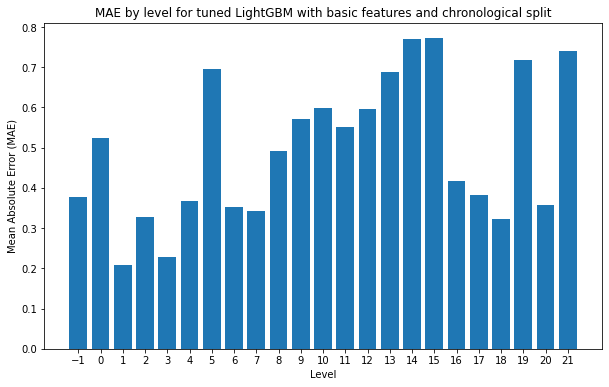

In [27]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for tuned LightGBM with basic features and chronological split",
)

In [28]:
predict = lgb_tuned.predict(X_test)
check_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.68

Round type: 0.5
RMSE: 0.72

Round type: 0.33
RMSE: 0.71

Round type: 0.45
RMSE: 0.72



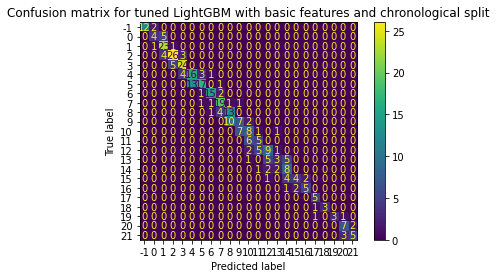

In [29]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with basic features and chronological split",
)

## Random split

In [30]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 8
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[57]	valid_0's l1: 0.336785	valid_0's l2: 0.238538


In [31]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.49
MAE: 0.34


In [33]:
results.loc[2] = ["random", "default", "basic", rmse, mae]

###### MAE by level

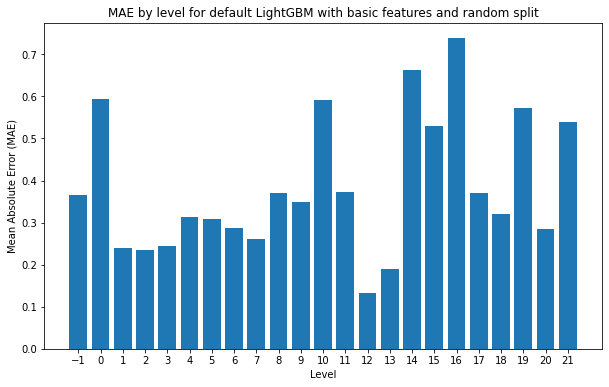

In [34]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for default LightGBM with basic features and random split",
)

In [35]:
check_round_predictions([0.5, 0.33, 0.45], y_test_random_split, y_pred_test)

Default:
RMSE: 0.49

Round type: 0.5
RMSE: 0.51

Round type: 0.33
RMSE: 0.57

Round type: 0.45
RMSE: 0.51



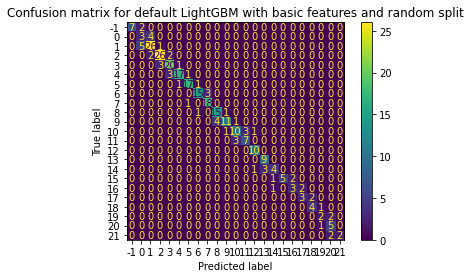

In [36]:
plot_confusion_matrix(
    y_pred_test,
    y_test_random_split,
    title="Confusion matrix for default LightGBM with basic features and random split",
)

### Tuning

In [37]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-05 13:59:29,263] A new study created in memory with name: no-name-b1e350ec-40f0-4193-a351-c8adcd819fc7
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.258013 + 0.076644
[200]	cv_agg's l2: 0.260521 + 0.0774082


feature_fraction, val_score: 0.256439:  14%|######4                                      | 1/7 [00:04<00:25,  4.19s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.256439 + 0.0774933
[100]	cv_agg's l2: 0.259912 + 0.0406326
[200]	cv_agg's l2: 0.256453 + 0.0413978


feature_fraction, val_score: 0.254810:  29%|############8                                | 2/7 [00:08<00:20,  4.14s/it]

Early stopping, best iteration is:
[157]	cv_agg's l2: 0.25481 + 0.0408438
[100]	cv_agg's l2: 0.258241 + 0.0722198
[200]	cv_agg's l2: 0.258632 + 0.0666509


feature_fraction, val_score: 0.254810:  43%|###################2                         | 3/7 [00:12<00:17,  4.34s/it]

Early stopping, best iteration is:
[157]	cv_agg's l2: 0.25481 + 0.0408438
[100]	cv_agg's l2: 0.272451 + 0.0599365
[200]	cv_agg's l2: 0.265913 + 0.0588899


feature_fraction, val_score: 0.254810:  57%|#########################7                   | 4/7 [00:17<00:13,  4.45s/it]

Early stopping, best iteration is:
[157]	cv_agg's l2: 0.25481 + 0.0408438
[100]	cv_agg's l2: 0.270189 + 0.0888317
[200]	cv_agg's l2: 0.265319 + 0.0820295


feature_fraction, val_score: 0.254810:  71%|################################1            | 5/7 [00:21<00:08,  4.18s/it]

Early stopping, best iteration is:
[157]	cv_agg's l2: 0.25481 + 0.0408438
[100]	cv_agg's l2: 0.257798 + 0.0525771
[200]	cv_agg's l2: 0.254695 + 0.0534193


feature_fraction, val_score: 0.254695:  86%|######################################5      | 6/7 [00:25<00:04,  4.39s/it]

[300]	cv_agg's l2: 0.256873 + 0.0532634
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.254695 + 0.0534193
[100]	cv_agg's l2: 0.257798 + 0.0525771
[200]	cv_agg's l2: 0.254695 + 0.0534193


feature_fraction, val_score: 0.254695: 100%|#############################################| 7/7 [00:31<00:00,  4.45s/it]


[300]	cv_agg's l2: 0.256873 + 0.0532634
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.254695 + 0.0534193


num_leaves, val_score: 0.254695:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.257798 + 0.0525771
[200]	cv_agg's l2: 0.254695 + 0.0534193


num_leaves, val_score: 0.254695:   5%|##5                                               | 1/20 [00:05<01:44,  5.49s/it]

[300]	cv_agg's l2: 0.256873 + 0.0532634
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.254695 + 0.0534193
[100]	cv_agg's l2: 0.257798 + 0.0525771
[200]	cv_agg's l2: 0.254695 + 0.0534193


num_leaves, val_score: 0.254695:  10%|#####                                             | 2/20 [00:10<01:30,  5.02s/it]

[300]	cv_agg's l2: 0.256873 + 0.0532634
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.254695 + 0.0534193
[100]	cv_agg's l2: 0.257798 + 0.0525771
[200]	cv_agg's l2: 0.254695 + 0.0534193


num_leaves, val_score: 0.254695:  15%|#######5                                          | 3/20 [00:15<01:24,  4.96s/it]

[300]	cv_agg's l2: 0.256873 + 0.0532634
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.254695 + 0.0534193
[100]	cv_agg's l2: 0.257798 + 0.0525771
[200]	cv_agg's l2: 0.254695 + 0.0534193


num_leaves, val_score: 0.254695:  20%|##########                                        | 4/20 [00:19<01:18,  4.88s/it]

[300]	cv_agg's l2: 0.256873 + 0.0532634
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.254695 + 0.0534193
[100]	cv_agg's l2: 0.257798 + 0.0525771
[200]	cv_agg's l2: 0.254695 + 0.0534193


num_leaves, val_score: 0.254695:  25%|############5                                     | 5/20 [00:24<01:12,  4.81s/it]

[300]	cv_agg's l2: 0.256873 + 0.0532634
Early stopping, best iteration is:
[200]	cv_agg's l2: 0.254695 + 0.0534193
[100]	cv_agg's l2: 0.256404 + 0.0603632
[200]	cv_agg's l2: 0.24933 + 0.0545713
[300]	cv_agg's l2: 0.249295 + 0.0546668


num_leaves, val_score: 0.248322:  30%|###############                                   | 6/20 [00:27<00:56,  4.07s/it]

Early stopping, best iteration is:
[256]	cv_agg's l2: 0.248322 + 0.0543039
[100]	cv_agg's l2: 0.251232 + 0.0598225
[200]	cv_agg's l2: 0.251149 + 0.0576456
[300]	cv_agg's l2: 0.253563 + 0.0567655


num_leaves, val_score: 0.248322:  35%|#################5                                | 7/20 [00:30<00:51,  3.94s/it]

Early stopping, best iteration is:
[256]	cv_agg's l2: 0.248322 + 0.0543039
[100]	cv_agg's l2: 0.252441 + 0.0599512
[200]	cv_agg's l2: 0.242832 + 0.0555712
[300]	cv_agg's l2: 0.241099 + 0.0553092


num_leaves, val_score: 0.240659:  40%|####################                              | 8/20 [00:33<00:41,  3.44s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.301246 + 0.0681613
[200]	cv_agg's l2: 0.268404 + 0.061889
[300]	cv_agg's l2: 0.261609 + 0.0585981


num_leaves, val_score: 0.240659:  45%|######################5                           | 9/20 [00:34<00:29,  2.72s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.257798 + 0.0525771
[200]	cv_agg's l2: 0.254695 + 0.0534193
[300]	cv_agg's l2: 0.256873 + 0.0532634


num_leaves, val_score: 0.240659:  50%|########################5                        | 10/20 [00:41<00:41,  4.18s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.257798 + 0.0525771
[200]	cv_agg's l2: 0.254695 + 0.0534193
[300]	cv_agg's l2: 0.256873 + 0.0532634


num_leaves, val_score: 0.240659:  55%|##########################9                      | 11/20 [00:47<00:42,  4.74s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.257798 + 0.0525771
[200]	cv_agg's l2: 0.254695 + 0.0534193
[300]	cv_agg's l2: 0.256873 + 0.0532634


num_leaves, val_score: 0.240659:  60%|#############################4                   | 12/20 [00:54<00:43,  5.45s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.387878 + 0.0762642
[200]	cv_agg's l2: 0.31863 + 0.0675435
[300]	cv_agg's l2: 0.299792 + 0.0653603


num_leaves, val_score: 0.240659:  65%|###############################8                 | 13/20 [00:55<00:28,  4.07s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.257798 + 0.0525771
[200]	cv_agg's l2: 0.254695 + 0.0534193
[300]	cv_agg's l2: 0.256873 + 0.0532634


num_leaves, val_score: 0.240659:  70%|##################################3              | 14/20 [01:02<00:28,  4.79s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.257798 + 0.0525771
[200]	cv_agg's l2: 0.254695 + 0.0534193
[300]	cv_agg's l2: 0.256873 + 0.0532634


num_leaves, val_score: 0.240659:  75%|####################################7            | 15/20 [01:12<00:32,  6.45s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.259599 + 0.0583301
[200]	cv_agg's l2: 0.259543 + 0.0576814
[300]	cv_agg's l2: 0.261979 + 0.0570858


num_leaves, val_score: 0.240659:  80%|#######################################2         | 16/20 [01:20<00:27,  6.87s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.257798 + 0.0525771
[200]	cv_agg's l2: 0.254695 + 0.0534193
[300]	cv_agg's l2: 0.256873 + 0.0532634


num_leaves, val_score: 0.240659:  85%|#########################################6       | 17/20 [01:25<00:19,  6.45s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.255662 + 0.0541371
[200]	cv_agg's l2: 0.2564 + 0.0531884
[300]	cv_agg's l2: 0.257761 + 0.0529348


num_leaves, val_score: 0.240659:  90%|############################################1    | 18/20 [01:30<00:12,  6.05s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.266218 + 0.0600404
[200]	cv_agg's l2: 0.249943 + 0.0591481
[300]	cv_agg's l2: 0.244124 + 0.0600947


num_leaves, val_score: 0.240659:  95%|##############################################5  | 19/20 [01:32<00:04,  4.63s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.257798 + 0.0525771
[200]	cv_agg's l2: 0.254695 + 0.0534193
[300]	cv_agg's l2: 0.256873 + 0.0532634


num_leaves, val_score: 0.240659: 100%|#################################################| 20/20 [01:36<00:00,  4.85s/it]


Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114


bagging, val_score: 0.240659:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.260484 + 0.058993
[200]	cv_agg's l2: 0.250189 + 0.0539878
[300]	cv_agg's l2: 0.250177 + 0.0527649


bagging, val_score: 0.240659:  10%|#####3                                               | 1/10 [00:02<00:22,  2.47s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.341179 + 0.0538735
[200]	cv_agg's l2: 0.314967 + 0.0545168
[300]	cv_agg's l2: 0.317766 + 0.0523064


bagging, val_score: 0.240659:  20%|##########6                                          | 2/10 [00:04<00:18,  2.35s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.255845 + 0.0615798
[200]	cv_agg's l2: 0.243871 + 0.0575946
[300]	cv_agg's l2: 0.240899 + 0.0533974


bagging, val_score: 0.240659:  30%|###############9                                     | 3/10 [00:07<00:16,  2.32s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.266713 + 0.0701716
[200]	cv_agg's l2: 0.254941 + 0.067413
[300]	cv_agg's l2: 0.250161 + 0.0614398


bagging, val_score: 0.240659:  40%|#####################2                               | 4/10 [00:09<00:13,  2.30s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.260794 + 0.0618416
[200]	cv_agg's l2: 0.256723 + 0.0581071
[300]	cv_agg's l2: 0.255884 + 0.0554892


bagging, val_score: 0.240659:  50%|##########################5                          | 5/10 [00:11<00:11,  2.25s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.25499 + 0.0579939
[200]	cv_agg's l2: 0.244875 + 0.0540426
[300]	cv_agg's l2: 0.243742 + 0.0509696


bagging, val_score: 0.240659:  60%|###############################8                     | 6/10 [00:13<00:08,  2.22s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.257025 + 0.0557063
[200]	cv_agg's l2: 0.243929 + 0.0539442
[300]	cv_agg's l2: 0.242884 + 0.050697


bagging, val_score: 0.240659:  70%|#####################################                | 7/10 [00:15<00:06,  2.20s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.252441 + 0.0599512
[200]	cv_agg's l2: 0.242832 + 0.0555712
[300]	cv_agg's l2: 0.241099 + 0.0553092


bagging, val_score: 0.240659:  80%|##########################################4          | 8/10 [00:17<00:04,  2.18s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.272943 + 0.0694164
[200]	cv_agg's l2: 0.26296 + 0.065772
[300]	cv_agg's l2: 0.260697 + 0.0658231


bagging, val_score: 0.240659:  90%|###############################################7     | 9/10 [00:20<00:02,  2.26s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.260765 + 0.0672696
[200]	cv_agg's l2: 0.250656 + 0.0578522
[300]	cv_agg's l2: 0.251254 + 0.0559774


bagging, val_score: 0.240659: 100%|####################################################| 10/10 [00:22<00:00,  2.26s/it]


Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114


feature_fraction_stage2, val_score: 0.240659:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.252441 + 0.0599512
[200]	cv_agg's l2: 0.242832 + 0.0555712
[300]	cv_agg's l2: 0.241099 + 0.0553092


feature_fraction_stage2, val_score: 0.240659:  17%|######3                               | 1/6 [00:02<00:11,  2.23s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.258943 + 0.047869
[200]	cv_agg's l2: 0.247533 + 0.044579
[300]	cv_agg's l2: 0.246317 + 0.0448788


feature_fraction_stage2, val_score: 0.240659:  33%|############6                         | 2/6 [00:04<00:09,  2.26s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.258943 + 0.047869
[200]	cv_agg's l2: 0.247533 + 0.044579
[300]	cv_agg's l2: 0.246317 + 0.0448788


feature_fraction_stage2, val_score: 0.240659:  50%|###################                   | 3/6 [00:06<00:07,  2.33s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.252441 + 0.0599512
[200]	cv_agg's l2: 0.242832 + 0.0555712
[300]	cv_agg's l2: 0.241099 + 0.0553092


feature_fraction_stage2, val_score: 0.240659:  67%|#########################3            | 4/6 [00:09<00:04,  2.24s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.258943 + 0.047869
[200]	cv_agg's l2: 0.247533 + 0.044579
[300]	cv_agg's l2: 0.246317 + 0.0448788


feature_fraction_stage2, val_score: 0.240659:  83%|###############################6      | 5/6 [00:11<00:02,  2.48s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.252441 + 0.0599512
[200]	cv_agg's l2: 0.242832 + 0.0555712
[300]	cv_agg's l2: 0.241099 + 0.0553092


feature_fraction_stage2, val_score: 0.240659: 100%|######################################| 6/6 [00:15<00:00,  2.57s/it]


Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114


regularization_factors, val_score: 0.240659:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.254577 + 0.0578377
[200]	cv_agg's l2: 0.24495 + 0.0539417
[300]	cv_agg's l2: 0.243539 + 0.0540197


regularization_factors, val_score: 0.240659:   5%|#9                                    | 1/20 [00:02<00:43,  2.31s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.264276 + 0.0581591
[200]	cv_agg's l2: 0.255001 + 0.0578041
[300]	cv_agg's l2: 0.251875 + 0.0581287


regularization_factors, val_score: 0.240659:  10%|###8                                  | 2/20 [00:04<00:38,  2.17s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.258255 + 0.0609735
[200]	cv_agg's l2: 0.246255 + 0.0564683
[300]	cv_agg's l2: 0.244996 + 0.0556435


regularization_factors, val_score: 0.240659:  15%|#####7                                | 3/20 [00:06<00:38,  2.24s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.294555 + 0.0653196
[200]	cv_agg's l2: 0.290831 + 0.0654547
[300]	cv_agg's l2: 0.290831 + 0.0654545


regularization_factors, val_score: 0.240659:  20%|#######6                              | 4/20 [00:07<00:28,  1.79s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548114
[100]	cv_agg's l2: 0.252441 + 0.0599512
[200]	cv_agg's l2: 0.242832 + 0.0555711
[300]	cv_agg's l2: 0.241099 + 0.0553092


regularization_factors, val_score: 0.240659:  25%|#########5                            | 5/20 [00:10<00:32,  2.14s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548113
[100]	cv_agg's l2: 0.252441 + 0.0599512
[200]	cv_agg's l2: 0.242832 + 0.0555711
[300]	cv_agg's l2: 0.241099 + 0.0553092


regularization_factors, val_score: 0.240659:  30%|###########4                          | 6/20 [00:12<00:30,  2.18s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548113
[100]	cv_agg's l2: 0.252441 + 0.0599512
[200]	cv_agg's l2: 0.242832 + 0.0555711
[300]	cv_agg's l2: 0.241099 + 0.0553091


regularization_factors, val_score: 0.240659:  35%|#############3                        | 7/20 [00:14<00:27,  2.10s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548113
[100]	cv_agg's l2: 0.252441 + 0.0599512
[200]	cv_agg's l2: 0.242832 + 0.0555711
[300]	cv_agg's l2: 0.241099 + 0.0553092


regularization_factors, val_score: 0.240659:  40%|###############2                      | 8/20 [00:16<00:25,  2.13s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548113
[100]	cv_agg's l2: 0.252441 + 0.0599512
[200]	cv_agg's l2: 0.242832 + 0.0555711
[300]	cv_agg's l2: 0.241099 + 0.0553092


regularization_factors, val_score: 0.240659:  45%|#################1                    | 9/20 [00:19<00:23,  2.12s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548113
[100]	cv_agg's l2: 0.252441 + 0.0599512
[200]	cv_agg's l2: 0.242832 + 0.0555711
[300]	cv_agg's l2: 0.241099 + 0.0553091


regularization_factors, val_score: 0.240659:  50%|##################5                  | 10/20 [00:21<00:20,  2.08s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548113
[100]	cv_agg's l2: 0.252441 + 0.0599512
[200]	cv_agg's l2: 0.242832 + 0.0555711
[300]	cv_agg's l2: 0.241099 + 0.0553092


regularization_factors, val_score: 0.240659:  55%|####################3                | 11/20 [00:23<00:18,  2.04s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548113
[100]	cv_agg's l2: 0.252441 + 0.0599512
[200]	cv_agg's l2: 0.242832 + 0.0555711
[300]	cv_agg's l2: 0.241099 + 0.0553092


regularization_factors, val_score: 0.240659:  60%|######################2              | 12/20 [00:24<00:16,  2.00s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548113
[100]	cv_agg's l2: 0.252441 + 0.0599512
[200]	cv_agg's l2: 0.242832 + 0.0555711
[300]	cv_agg's l2: 0.241099 + 0.0553092


regularization_factors, val_score: 0.240659:  65%|########################             | 13/20 [00:27<00:14,  2.04s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240659 + 0.0548113
[100]	cv_agg's l2: 0.252441 + 0.0599511
[200]	cv_agg's l2: 0.242832 + 0.0555711
[300]	cv_agg's l2: 0.241099 + 0.0553091


regularization_factors, val_score: 0.240658:  70%|#########################9           | 14/20 [00:28<00:12,  2.01s/it]

Early stopping, best iteration is:
[285]	cv_agg's l2: 0.240658 + 0.0548113
[100]	cv_agg's l2: 0.252304 + 0.0593567
[200]	cv_agg's l2: 0.242778 + 0.0556879
[300]	cv_agg's l2: 0.240632 + 0.0535143


regularization_factors, val_score: 0.240070:  75%|###########################7         | 15/20 [00:31<00:10,  2.07s/it]

[400]	cv_agg's l2: 0.241736 + 0.0520153
Early stopping, best iteration is:
[322]	cv_agg's l2: 0.24007 + 0.0531642
[100]	cv_agg's l2: 0.253267 + 0.0609199
[200]	cv_agg's l2: 0.241486 + 0.0570127
[300]	cv_agg's l2: 0.240056 + 0.0532688


regularization_factors, val_score: 0.239830:  80%|#############################6       | 16/20 [00:33<00:08,  2.03s/it]

Early stopping, best iteration is:
[289]	cv_agg's l2: 0.23983 + 0.0531894
[100]	cv_agg's l2: 0.254783 + 0.0614144
[200]	cv_agg's l2: 0.244797 + 0.0583554
[300]	cv_agg's l2: 0.243266 + 0.055293


regularization_factors, val_score: 0.239830:  85%|###############################4     | 17/20 [00:35<00:06,  2.02s/it]

Early stopping, best iteration is:
[289]	cv_agg's l2: 0.23983 + 0.0531894
[100]	cv_agg's l2: 0.253732 + 0.0606296
[200]	cv_agg's l2: 0.242582 + 0.0558327
[300]	cv_agg's l2: 0.242376 + 0.0528967


regularization_factors, val_score: 0.239830:  90%|#################################3   | 18/20 [00:37<00:03,  2.00s/it]

Early stopping, best iteration is:
[289]	cv_agg's l2: 0.23983 + 0.0531894
[100]	cv_agg's l2: 0.252304 + 0.0593567
[200]	cv_agg's l2: 0.243078 + 0.056176
[300]	cv_agg's l2: 0.241087 + 0.0542631


regularization_factors, val_score: 0.239830:  95%|###################################1 | 19/20 [00:39<00:02,  2.10s/it]

Early stopping, best iteration is:
[289]	cv_agg's l2: 0.23983 + 0.0531894
[100]	cv_agg's l2: 0.252441 + 0.0599512
[200]	cv_agg's l2: 0.242832 + 0.0555712
[300]	cv_agg's l2: 0.241099 + 0.0553092


regularization_factors, val_score: 0.239830: 100%|#####################################| 20/20 [00:41<00:00,  2.08s/it]


Early stopping, best iteration is:
[289]	cv_agg's l2: 0.23983 + 0.0531894


min_data_in_leaf, val_score: 0.239830:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.231428 + 0.0515989
[200]	cv_agg's l2: 0.224333 + 0.0461204
[300]	cv_agg's l2: 0.221452 + 0.0431634


min_data_in_leaf, val_score: 0.221219:  20%|#########                                    | 1/5 [00:02<00:08,  2.00s/it]

Early stopping, best iteration is:
[290]	cv_agg's l2: 0.221219 + 0.0430543
[100]	cv_agg's l2: 0.238017 + 0.0525654
[200]	cv_agg's l2: 0.232833 + 0.0535166
[300]	cv_agg's l2: 0.234068 + 0.0552565


min_data_in_leaf, val_score: 0.221219:  40%|##################                           | 2/5 [00:04<00:06,  2.02s/it]

Early stopping, best iteration is:
[290]	cv_agg's l2: 0.221219 + 0.0430543
[100]	cv_agg's l2: 0.275405 + 0.0699075
[200]	cv_agg's l2: 0.268938 + 0.0698622
[300]	cv_agg's l2: 0.268568 + 0.0692199


min_data_in_leaf, val_score: 0.221219:  60%|###########################                  | 3/5 [00:06<00:04,  2.16s/it]

Early stopping, best iteration is:
[290]	cv_agg's l2: 0.221219 + 0.0430543
[100]	cv_agg's l2: 0.813372 + 0.0677509
[200]	cv_agg's l2: 0.78594 + 0.0758174
[300]	cv_agg's l2: 0.775757 + 0.0829916


min_data_in_leaf, val_score: 0.221219:  80%|####################################         | 4/5 [00:08<00:01,  1.96s/it]

Early stopping, best iteration is:
[290]	cv_agg's l2: 0.221219 + 0.0430543
[100]	cv_agg's l2: 0.354147 + 0.0743752
[200]	cv_agg's l2: 0.346122 + 0.0692369
[300]	cv_agg's l2: 0.344498 + 0.066716


min_data_in_leaf, val_score: 0.221219: 100%|#############################################| 5/5 [00:09<00:00,  2.00s/it]

Early stopping, best iteration is:
[290]	cv_agg's l2: 0.221219 + 0.0430543


In [38]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.22121891350593598
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 3.052363566837987e-07
    lambda_l2: 0.003786022953136945
    num_leaves: 9
    feature_fraction: 0.7
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 5


In [39]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [40]:
rmse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.51
MAE test: 0.33



In [41]:
results.loc[3] = ["random", "Optuna", "basic", rmse, mae]

###### MAE by level

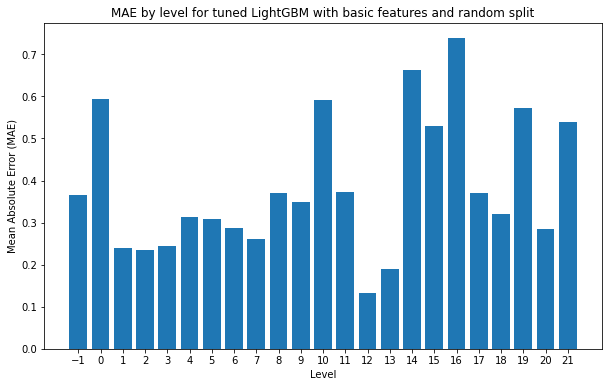

In [42]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for tuned LightGBM with basic features and random split",
)

In [43]:
predict = lgb_tuned.predict(X_test)
check_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.34

Round type: 0.5
RMSE: 0.37

Round type: 0.33
RMSE: 0.35

Round type: 0.45
RMSE: 0.36



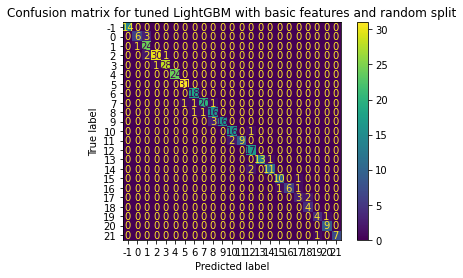

In [44]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with basic features and random split",
)

## Summary

In [45]:
results

,Split type,Tuning type,Set of features,RMSE,MAE
0,chronological,default,basic,0.669004,0.467604
1,chronological,Optuna,basic,0.683463,0.480905
2,random,default,basic,0.488404,0.336785
3,random,Optuna,basic,0.508860,0.331067


In [46]:
from training.results import plot_summary

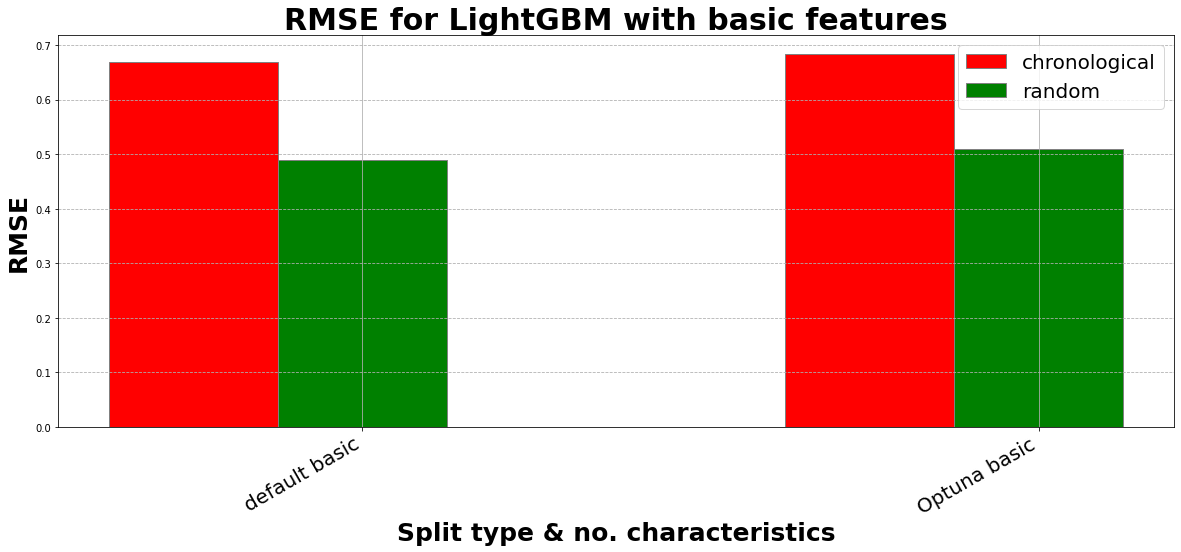

In [47]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with basic features")

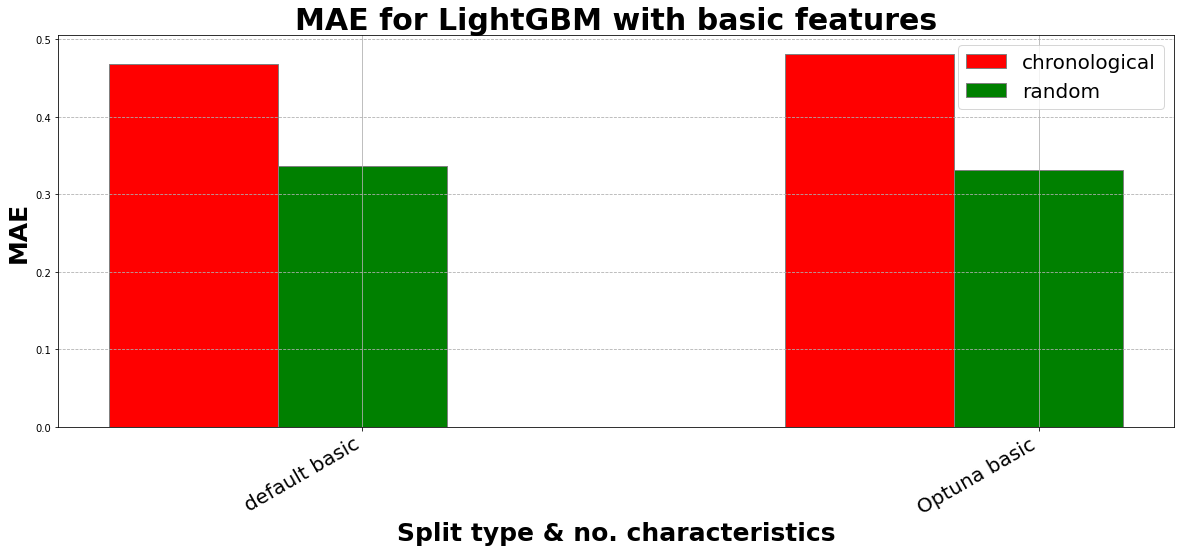

In [48]:
plot_summary(results, "MAE", title="MAE for LightGBM with basic features")

In [49]:
results.to_json("./lightgbm_basic_results.json", indent=2)